##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

**Modified by Eugene Luo**

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Fast Style Transfer for Arbitrary Styles


Based on the model code in [magenta](https://github.com/tensorflow/magenta/tree/master/magenta/models/arbitrary_image_stylization) and the publication:

[Exploring the structure of a real-time, arbitrary neural artistic stylization
network](https://arxiv.org/abs/1705.06830).
*Golnaz Ghiasi, Honglak Lee,
Manjunath Kudlur, Vincent Dumoulin, Jonathon Shlens*,
Proceedings of the British Machine Vision Conference (BMVC), 2017.

== Additions and modifications by Vladimir Shapiro


## Setup

Let's start with importing TF-2 and all relevant dependencies.

In [2]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.test.is_gpu_available())

TF Version:  2.8.0
TF-Hub version:  0.12.0
Eager mode enabled:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available:  True


In [3]:
# @title Define image loading and visualization functions  { display-mode: "form" }

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image



@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img



def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()



def load_local_image(image_bytes, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
   # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = image_bytes
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img



## Import TF-Hub module

In [4]:
# Load TF-Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

First, try the original (from the Tensorflow source) files:

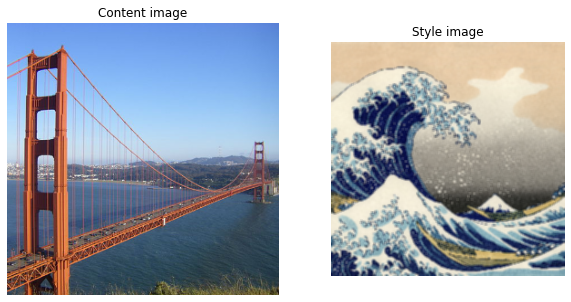

In [5]:
# @title Load example images  { display-mode: "form" }
#@param {type:"string"}
content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'  
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'  # @param {type:"string"}
output_image_size = 300  # @param {type:"integer"}



# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.



content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

## Demonstrate image stylization

The signature of this hub module for image stylization is:
```
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]
```
Where `content_image`, `style_image`, and `stylized_image` are expected to be 4-D Tensors with shapes `[batch_size, image_height, image_width, 3]`.

In the current example we provide only single images and therefore the batch dimension is 1, but one can use the same module to process more images at the same time.

The input and output values of the images should be in the range [0, 1].

The shapes of content and style image don't have to match. Output image shape
is the same as the content image shape.

## Calculate and Display

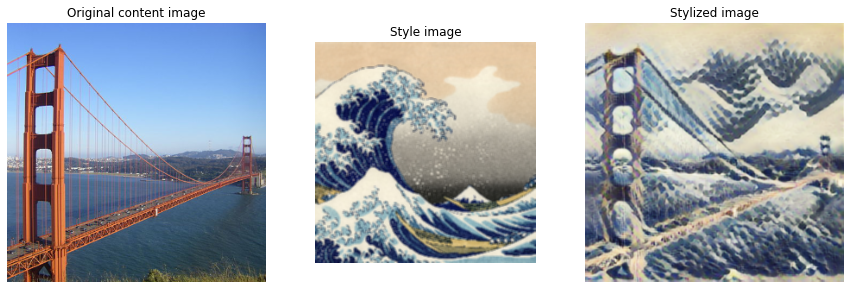

In [6]:
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]



# Visualize input images and the generated stylized image.



show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

Let's get as well some images to play with.

Browse to the style file  to be uploaded


Saving NortheasternLogo_256x256.jpg to NortheasternLogo_256x256 (2).jpg
User uploaded file NortheasternLogo_256x256.jpg with length 24546 fbytes
Browse to the content file to be uploaded


Saving 123441834_10157714795386616_4203173542922395020_n.jpg to 123441834_10157714795386616_4203173542922395020_n (3).jpg
User uploaded content file 123441834_10157714795386616_4203173542922395020_n.jpg with length 522264 fbytes


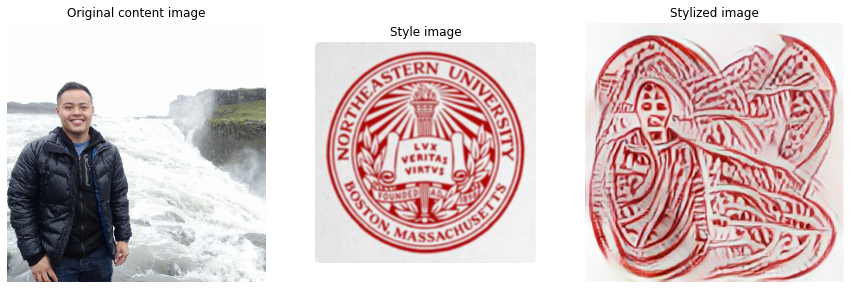

In [7]:
from google.colab import files
# load style image from the local filesystem
print("Browse to the style file  to be uploaded") 
style_uploaded = files.upload()
for fn in style_uploaded.keys():
  print("User uploaded file {name} with length {length} fbytes".format(name=fn, 
                                                      length=len(style_uploaded[fn])))
style_img = plt.imread(fn).astype(np.float32)[np.newaxis, ...]



# load content image from the local filesystem
print("Browse to the content file to be uploaded") 
content_uploaded = files.upload()
for fn in content_uploaded.keys():
  print("User uploaded content file {name} with length {length} fbytes".format(name=fn,
                                                      length=len(content_uploaded[fn])))
content_img = plt.imread(fn).astype(np.float32)[np.newaxis, ...]



# @title Load example images  { display-mode: "form" }
output_image_size = 300  # @param {type:"integer"}




# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.


content_image = load_local_image(content_img, content_img_size) #load_image(content_image_url, content_img_size)
style_image = load_local_image(style_img, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
#show_n([content_image, style_image], ['Content image', 'Style image'])



# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]



# Visualize input images and the generated stylized image.
show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

Browse to the style file  to be uploaded


Saving the-persistence-of-memory-1931-1140x867.jpg to the-persistence-of-memory-1931-1140x867 (1).jpg
User uploaded file the-persistence-of-memory-1931-1140x867.jpg with length 170790 fbytes
Browse to the content file to be uploaded


Saving 123441834_10157714795386616_4203173542922395020_n.jpg to 123441834_10157714795386616_4203173542922395020_n (4).jpg
User uploaded content file 123441834_10157714795386616_4203173542922395020_n.jpg with length 522264 fbytes


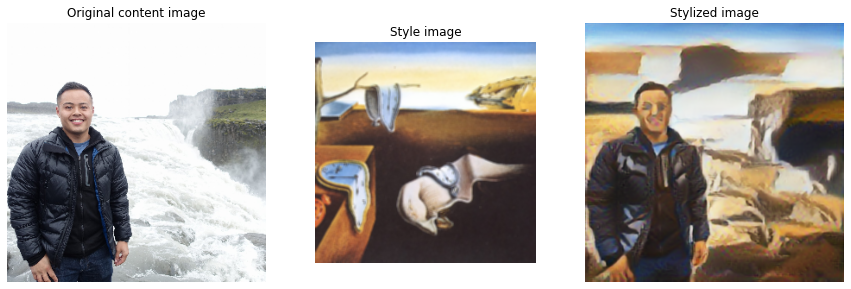

In [8]:
from google.colab import files
# load style image from the local filesystem
print("Browse to the style file  to be uploaded") 
style_uploaded = files.upload()
for fn in style_uploaded.keys():
  print("User uploaded file {name} with length {length} fbytes".format(name=fn, 
                                                      length=len(style_uploaded[fn])))
style_img = plt.imread(fn).astype(np.float32)[np.newaxis, ...]

# load content image from the local filesystem
print("Browse to the content file to be uploaded") 
content_uploaded = files.upload()
for fn in content_uploaded.keys():
  print("User uploaded content file {name} with length {length} fbytes".format(name=fn,
                                                      length=len(content_uploaded[fn])))
content_img = plt.imread(fn).astype(np.float32)[np.newaxis, ...]

# @title Load example images  { display-mode: "form" }
output_image_size = 300  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_local_image(content_img, content_img_size) #load_image(content_image_url, content_img_size)
style_image = load_local_image(style_img, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
#show_n([content_image, style_image], ['Content image', 'Style image'])

# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

# Visualize input images and the generated stylized image.
show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])